In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm

%matplotlib inline

In [2]:
train = pd.read_csv('../input/feedback-prize-2021/train.csv')
train.shape

(144293, 8)

In [3]:
train.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


<AxesSubplot:xlabel='discourse_type', ylabel='count'>

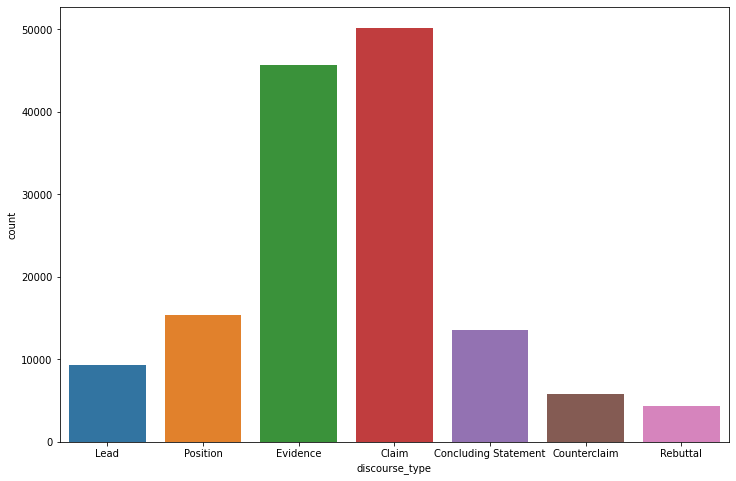

In [4]:
plt.figure(figsize=(12,8))
sns.countplot(x='discourse_type', data=train)

In [5]:
# def generate_test_df():
#     test_dir = "../input/feedback-prize-2021/train"
#     test_files = os.listdir(test_dir)
    
#     test_names = []
#     test_texts = []
#     for f in os.listdir(test_dir):
#         test_names.append(f.replace('.txt', ''))
#         test_texts.append(open(test_dir+'/'+f, 'r').read())
        
#     test_texts = pd.DataFrame({'id':test_names, 'text':test_texts})
    
#     discourse_id = []
#     discourse_text = []
#     discourse_start =[] 
#     discourse_end = []
#     predictionstring = []
#     for text in range(len(test_texts.text)):
#         doc = test_texts.text[text]
#         paras = re.split(r'[.]\n',doc)
#         start = 0
#         for para in paras:
#             positions = re.findall(r'\w+[.]', para)
#             if len(positions) <=2 :
#                 txts = re.split(r'[.]\s',para)
#                 for i in txts:
#                     discourse_text.append(i)
#                     length = len(i.split())
#                     end = start + length
#                     l = list(range(start+1,end+1 ))
#                     l = [str(j) for j in l]
#                     l = ' '.join(l)
#                     predictionstring.append(l)
#                     discourse_start.append(start+1)
#                     discourse_end.append(end)
#                     discourse_id.append(test_texts.id[text])
#                     start += length

#             else: 
#                 if len(positions)%2 == 0:
#                     split_pos = int(len(positions)/2)
#                     split_word = positions[split_pos]
#                 else :
#                     split_pos = int((len(positions)+1)/2)
#                     split_word = positions[split_pos]

#                 words = para.split(' ')
#                 position = words.index(split_word)
#                 part1 = words[:position]
#                 part2 = words[position:]
#                 part1 = ' '.join(part1)
#                 part2 = ' '.join(part2)
#                 parts = [part1 ,part2]
#                 for i in parts:
#                     discourse_text.append(i)
#                     length = len(i.split())
#                     end = start + length
#                     l = list(range(start+1,end+1 ))
#                     l = [str(k) for k in l]
#                     l = ' '.join(l)
#                     predictionstring.append(l)
#                     discourse_start.append(start+1)
#                     discourse_end.append(end)
#                     discourse_id.append(test_texts.id[text])
#                     start += length

#     testing_data =pd.DataFrame() 
#     testing_data['discourse_id'] =discourse_id
#     testing_data['discourse_text'] = discourse_text
#     testing_data['discourse_start'] = discourse_start
#     testing_data['discourse_end'] = discourse_end
#     testing_data['predictionstring'] = predictionstring
#     return testing_data


In [6]:
# test = generate_test_df()
# test.head()

In [7]:
TEST_PATH = "../input/feedback-prize-2021/test"

def get_test_text(a_id):
    a_file = f"{TEST_PATH}/{a_id}.txt"
    with open(a_file, "r") as fp:
        txt = fp.read()
    return txt

def create_df_test():
    test_ids = [f[:-4] for f in os.listdir(TEST_PATH)] #Remove the last 4 characters ('.txt') in the filenames such as '0FB0700DAF44.txt'.
    test_data = []
    for test_id in test_ids:
        text = get_test_text(test_id)
        sentences = nltk.sent_tokenize(text)
        id_sentences = []
        idx = 0 
        for sentence in sentences:
            id_sentence = []
            words = sentence.split()
            # I created this heuristic for mapping words in sentences to "word indices"
            # This is not definitive and might have strong drawbacks and problems
            for w in words:
                id_sentence.append(idx)
                idx+=1
            id_sentences.append(id_sentence)
        test_data += list(zip([test_id] * len(sentences), sentences, id_sentences))
    df_test = pd.DataFrame(test_data, columns=['id', 'discourse_text', 'ids'])
    return df_test

In [8]:
df_test = create_df_test()
df_test.head()

,id,discourse_text,ids
0,0FB0700DAF44,"During a group project, have you ever asked a ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,0FB0700DAF44,"Or, when you were studying for a math test, di...","[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2..."
2,0FB0700DAF44,Asking for other's opinions is especially bene...,"[41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 5..."
3,0FB0700DAF44,"Likewise, being diverse and asking many people...","[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 7..."
4,0FB0700DAF44,This is especially important as knowing multip...,"[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 9..."


In [9]:
df_test['predictionstring'] = df_test['ids'].apply(lambda x: ' '.join([str(i) for i in x]))
df_test.head()

,id,discourse_text,ids,predictionstring
0,0FB0700DAF44,"During a group project, have you ever asked a ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
1,0FB0700DAF44,"Or, when you were studying for a math test, di...","[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...",16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 3...
2,0FB0700DAF44,Asking for other's opinions is especially bene...,"[41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 5...",41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 5...
3,0FB0700DAF44,"Likewise, being diverse and asking many people...","[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 7...",65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 8...
4,0FB0700DAF44,This is especially important as knowing multip...,"[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 9...",84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 9...


In [10]:
df_test = df_test.drop('ids', axis=1)

In [11]:
df_test.head()

,id,discourse_text,predictionstring
0,0FB0700DAF44,"During a group project, have you ever asked a ...",0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
1,0FB0700DAF44,"Or, when you were studying for a math test, di...",16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 3...
2,0FB0700DAF44,Asking for other's opinions is especially bene...,41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 5...
3,0FB0700DAF44,"Likewise, being diverse and asking many people...",65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 8...
4,0FB0700DAF44,This is especially important as knowing multip...,84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 9...


In [12]:
df = train.append(df_test)

## Preprocessing

In [13]:
def clean_text(text, remove_stopwords=True, stem_words=False, lemma=True):
    text = str(text).lower().split()
    
    if remove_stopwords:
        stops = stopwords.words("english")
        text = [x for x in text if not x in stops]
        
    text = ' '.join(text)
    
    text = re.sub(r"[-()\"#/<>!@&;*:<>{}`'+=~%|.!?,_]", " ", text)
    text = re.sub(r"\]", " ", text)
    text = re.sub(r"\[", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\\", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"  ", " ", text)
    text = re.sub(r"   ", " ", text)
    text = re.sub(r"   ", " ", text)
    text = re.sub(r"0x00", "", text)
    
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stem_words = [stemmer.stem(x) for x in text]
        text = " ".join(text)
        
    if lemma:
        text = text.split()
        lem = WordNetLemmatizer()
        lemmatized = [lem.lemmatize(x, "v") for x in text]
        text = " ".join(text)
        
    return text

In [14]:
%%time
df['cleaned_text'] = df.discourse_text.apply(clean_text)

CPU times: user 57.1 s, sys: 2.85 s, total: 60 s
Wall time: 1min


In [15]:
df.iloc[0]['discourse_text']

'Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving.'

In [16]:
df.iloc[0]['cleaned_text']

'modern humans today always phone always phone 5 hours day stop all text back forward group chats social media even driving'

## TFIDF Vectorizer

In [17]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=1000)
tfidf_vect.fit(df['cleaned_text'])

TfidfVectorizer(max_features=1000, token_pattern='\\w{1,}')

In [18]:
train_tfidf = tfidf_vect.fit_transform(df[:train.shape[0]]['cleaned_text'])
test_tfidf = tfidf_vect.transform(df[train.shape[0]:]['cleaned_text'])


In [19]:
features = tfidf_vect.get_feature_names()
features[:20]

['000',
 '1',
 '2',
 '2000',
 '2001',
 '25',
 '3',
 '4',
 '5',
 '6',
 '60',
 '7',
 'a',
 'ability',
 'able',
 'about',
 'access',
 'accident',
 'accidents',
 'according']

## Random Forest

In [20]:
#cv = KFold(n_splits=10, random_state=1, shuffle=True)
rf_model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
#scores = cross_val_score(rf_model, train_tfidf, train['discourse_type'], scoring='accuracy', cv=cv)

In [21]:
#print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [22]:
%%time
rf_model.fit(train_tfidf, train['discourse_type'])

CPU times: user 1min 43s, sys: 144 ms, total: 1min 43s
Wall time: 1min 43s


RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [23]:
rf_pred = rf_model.predict(test_tfidf) 

## Submission

In [24]:
submission_df = pd.DataFrame()
submission_df['id'] = df_test['id']
submission_df['class'] = rf_pred# label of y_predict
submission_df['predictionstring'] = df_test['predictionstring']


In [25]:
submission_df.head()

,id,class,predictionstring
0,0FB0700DAF44,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
1,0FB0700DAF44,Lead,16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 3...
2,0FB0700DAF44,Evidence,41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 5...
3,0FB0700DAF44,Claim,65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 8...
4,0FB0700DAF44,Claim,84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 9...


In [26]:
submission_df.to_csv('submission.csv', index=False)